In [333]:
import gensim
import os
import pandas as pd
import numpy as np
from hashstash import HashStash, stashed_result
hs = HashStash('improving_ecco')

@hs.stashed_result
def get_words():
    import pandas as pd
    df_words = pd.read_csv('/Users/ryan/DH/data/fields/data.words.byu.tsv', sep='\t')
    return set(df_words.word)

def get_model_fn(decade, run=1):
    return f"../data/models/ecco/word2vec.ECCO.{decade}.run_{run:02d}.skipgram_n=5.model.txt.gz"

def get_vocab_fn(decade, run=1):
    return f"../data/models/ecco/word2vec.ECCO.{decade}.run_{run:02d}.skipgram_n=5.model.vocab.txt"

def load_model(decade, run=1):
    fn = get_model_fn(decade, run)
    fn_vocab = get_vocab_fn(decade, run)
    return gensim.models.KeyedVectors.load_word2vec_format(fn, binary=False, fvocab=fn_vocab)


In [334]:
model_dir = '../data/models/ecco/'

def collect_neighbors(word, n=100, num_runs=2):
    ld=[]
    for run in range(1, num_runs+1):
        for dec in range(1700, 1800, 10):
            decstr = f'{dec}-{dec+9}'
            if not os.path.exists(get_model_fn(decstr, run)):
                continue
            try:
                ld.extend(do_collect_neighbors(word, decstr, run, n))
            except Exception as e:
                print(e)
                pass
    odf = pd.DataFrame(ld)
    odf['num_decades'] = odf.groupby('word')['word'].transform('count')
    return odf


@stashed_result
def do_collect_neighbors(word,decstr,run,n=100):
    print(word, decstr, run)
    model = load_model(decstr, run)
    rank=0
    ld=[]
    words = get_words()
    for w, s in model.most_similar(word, topn=n*10):
        if w in words:
            rank+=1
            if rank <= n:
                d = {
                    'decade': decstr,
                    'run': run,
                    'rank': rank,
                    'word': w,
                    'similarity': s
                }
                ld.append(d)
    return ld

In [335]:
df=collect_neighbors("improvement", num_runs=10)
# df_word2 = collect_neighbors("culture", num_runs=10)
# df_word2


In [336]:
def agg_by_run(df, n=100):
    df2 = df.groupby(["decade", "word"]).median().drop(columns=["run"]).reset_index()
    df2["avg_rank"] = df2["rank"]  # .apply(lambda x: x-1 if random.random()>.5 else 1)
    df2 = pd.concat(
        gdf.sort_values(
            by=["avg_rank", "similarity", "word"],
            ascending=[True, False, True],
        ).assign(rank=list(range(1, len(gdf) + 1)))
        for _, gdf in df2.query('num_decades>1').groupby("decade")
    ).query(f'rank<={n}')
    return df2

def pivot_neighbors(df, n=100):
    import random
    df2 = agg_by_run(df)

    # Pivot the table to get decades as columns
    df3 = df2.pivot(
        index='word',
        columns='decade',
        values='rank'
    )

    # Optionally, round ranks to integers
    df3 = df3.applymap(lambda x: int(x) if pd.notna(x) else '')

    # Add average rank (ignoring empty cells)
    df3['avg_rank'] = df3.replace('', np.nan).mean(axis=1)

    # Add number of decades each word appears in
    df3['num_decades'] = [len([x for x in row if x != ''])-1 for row in df3.values]

    # Sort and add overall rank
    df3 = df3.sort_values(by=['num_decades','avg_rank'], ascending=[False,True])
    df3['rank'] = range(1, len(df3) + 1)

    return df3.sort_values(by=['num_decades','avg_rank'],ascending=[False,True]).drop(columns=['avg_rank'])


In [337]:
agg_by_run(df)

,decade,word,rank,similarity,num_decades,avg_rank
36,1700-1709,bettering,1,0.801393,73.0,1.0
115,1700-1709,improving,2,0.781717,76.0,4.0
57,1700-1709,cultivation,3,0.783174,72.0,4.5
156,1700-1709,perfecting,4,0.780335,59.0,4.5
29,1700-1709,attainment,5,0.777478,76.0,4.5
...,...,...,...,...,...,...
2510,1790-1799,re-establishment,96,0.692922,21.0,80.0
2444,1790-1799,estimate,97,0.673185,36.0,80.0
2484,1790-1799,lesions,98,0.692869,3.0,81.0
2526,1790-1799,sociability,99,0.672882,3.0,81.0


In [338]:
dfp=pivot_neighbors(df)
dfp.to_csv('ecco_neighbors.csv')

In [339]:
def plot_ranks(df):
    import plotnine as p9
    from scipy import stats

    p9.options.figure_size = (15, 9)
    figdf = agg_by_run(df)

    def calc_regression(group):
        try:
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                group["decade_num"], group["similarity"]
            )
            return pd.Series(
                {
                    "slope": slope,
                    "intercept": intercept,
                    "r_value": r_value,
                    "p_value": p_value,
                    "support": len(group["decade_num"]),
                }
            )
        except Exception as e:
            return pd.Series(
                {
                    "slope": np.nan,
                    "intercept": np.nan,
                    "r_value": np.nan,
                    "p_value": np.nan,
                    "support": np.nan,
                }
            )

    regression_results = figdf.groupby("word").apply(calc_regression).reset_index()

    # Merge regression results back to the original dataframe
    figdf = figdf.merge(regression_results, on="word")
    figdf["significant"] = figdf["p_value"] < 0.05

    # figdf = figdf.query('rank <= 25')
    figdf["num_decades"] = figdf.groupby("word")["word"].transform("count")
    figdf["decade_num"] = figdf["decade"].apply(lambda x: int(x.split("-")[0]))

    # Sort words by absolute slope value
    # word_order = figdf.groupby('word')['slope'].mean().abs().sort_values(ascending=False).index

    figdf = figdf.query("rank <= 25")
    # figdf = figdf.query('num_decades >= 2')
    fig = p9.ggplot(figdf, p9.aes(x="decade", y="rank", color="significant"))
    fig += p9.geom_line(
        p9.aes(group="word"), alpha=0.4, size=0.5, linetype="dashed"
    )  # , data=figdf.query('num_decades >= 5'))
    fig += p9.geom_text(p9.aes(label="word"), size=10)
    # fig += p9.facet_wrap('corpus')
    fig += p9.scale_y_reverse()
    fig += p9.theme_classic()
    fig += p9.scale_size_manual(values={True: 15, False: 10})
    fig += p9.scale_color_manual(values={True: "red", False: "black"})

    # remove color legend
    fig += p9.theme(legend_position="none")
    return fig

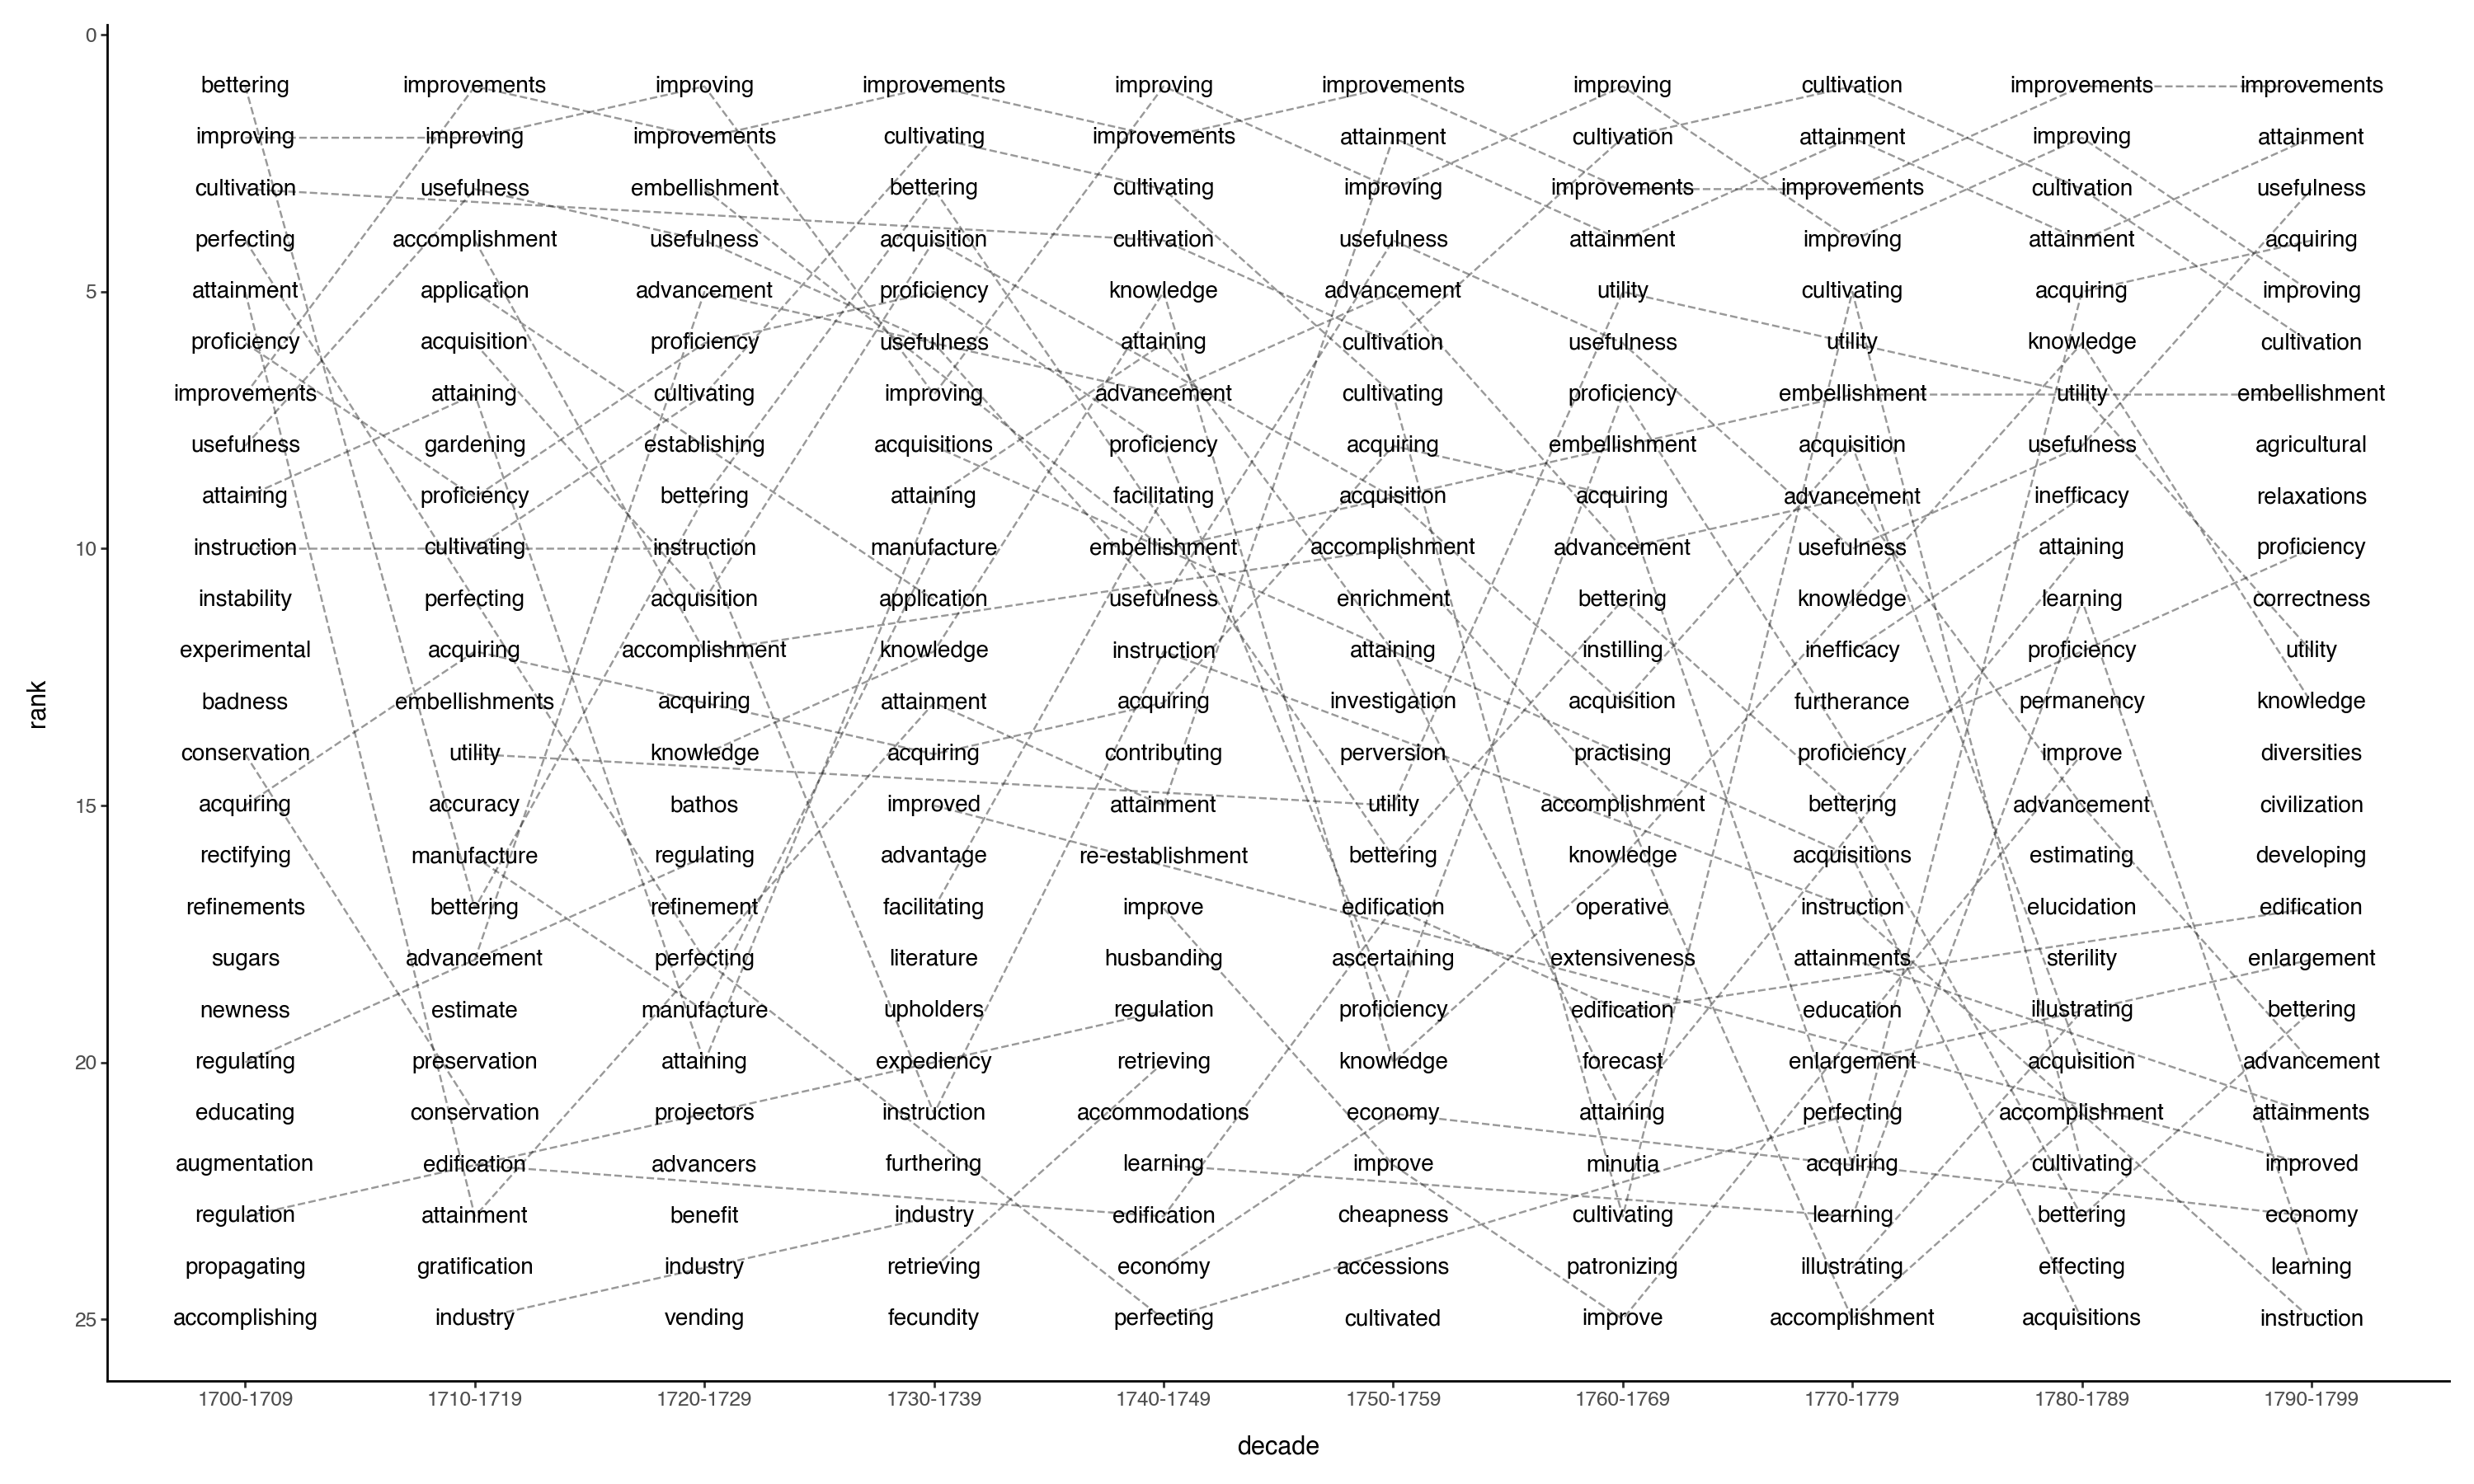

In [340]:
fig = plot_ranks(df)
fig.save('ecco_neighbors.png')
fig

In [309]:
# plot_ranks(df_word2)

In [325]:
# # !pip install openpyxl
# df=pd.read_excel('../data/metadata/corpus-metadata.ECCO.xlsx')
# df['decade'] = df['year'].apply(lambda x: f'{x//10*10}-{x//10*10+9}')
# df.query('1700<=year<1800').decade.value_counts().sort_index()

,ESTCID,birthDate,collation,currentVolume,deathDate,documentID,fullTitle,holdings_num_libraries,id,imprintCity,...,notes,personalName_a,personalName_d,pubDate,publicationPlace,sourceLibrary,subcorpus,totalPages,totalVolumes,year
0,T089174,1672,"3v.,plates : ill.,port. ; 12Â°",Volume 3,1719,108000303,"The miscellaneous works, in verse and prose, o...",19,GenRef/0108000303,London,...,NaN,"Addison, Joseph,",1672-1719,17770101,London,British Library,GenRef,298.0,3,1777
1,W031873,NaN,"18v. : ill., maps ; 4Â°",Volume 10,NaN,1115900110,"Encyclopaedia; or, A dictionary of arts, scien...",54,GenRef/1115900110,Philadelphia,...,Based on the third edition of the Encyclopaedi...,NaN,NaN,17980101,Philadelphia,British Library,GenRef,407.0,18,1798
2,T070635,NaN,40p. ; 8Â°,0,NaN,90801200,"The life of Jonathan Wilde, thief-taker genera...",1,GenRef/0090801200,Northampton,...,"Other editions are by ""H. D."" Sometimes attri...","Wilde, Jonathan",NaN,17250101,Northampton,British Library,GenRef,39.0,0,1725
3,T081233,NaN,2v. ; 8Â°,Volume 2,NaN,513401302,A catalogue of the libraries of the late Right...,13,GenRef/0513401302,[London],...,The receipt given for the purchase of the two ...,NaN,NaN,17540101,London,British Library,GenRef,496.0,2,1754
4,T122593,1613,"3v.,plates : ports. ; 8Â°",Volume 3,1703,93100203,"The works of Monsieur de St. Evremond, made En...",45,GenRef/0093100203,London,...,Dedication signed: P. des Maizeaux. Translate...,"Saint-Evremond,",1613-1703,17280101,London,British Library,GenRef,425.0,3,1728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154851,T019806,NaN,"[2],vii,[1],50p. ; 8Â°",0,NaN,64802800,The bystander.,5,SSAndFineArt/0064802800,London,...,with a half-title.,NaN,NaN,17720101,London,British Library,SSAndFineArt,56.0,0,1772
154852,T133584,NaN,"[4],145,[3]p. ; 8Â°",0,NaN,130000200,"Letters on female education, addressed to a ma...",7,SSAndFineArt/0130000200,London,...,With a final advertisement leaf.,NaN,NaN,17770101,London,British Library,SSAndFineArt,150.0,0,1777
154853,T181104,1768,"[2],215,[1]p. ; 8Â°",0,1815,1223401700,"Narrative of the deportation to Cayenne, of Ba...",9,SSAndFineArt/1223401700,London,...,With a half-title. Also issued as part of: 'H...,NaN,NaN,17990101,London,Bodleian Library (Oxford),SSAndFineArt,218.0,0,1799
154854,T094310,NaN,24p. ; 8Â°,0,NaN,669902600,"Some thoughts on the nature of paper-credit, r...",15,SSAndFineArt/0669902600,Dublin,...,NaN,NaN,NaN,17600101,Dublin,British Library,SSAndFineArt,23.0,0,1760


decade
1700-1709     8907
1710-1719    12058
1720-1729    10095
1730-1739    10665
1740-1749    11521
1750-1759    13383
1760-1769    16399
1770-1779    18093
1780-1789    20534
1790-1799    29444
Name: count, dtype: int64

In [59]:
import numpy as np
from fastdist import fastdist


def local_neighborhood_distance(word, model1, model2, n=25):
    neighbors1 = [w for w, s in model1.most_similar(word, topn=n*10) if w in words][:n]
    neighbors2 = [w for w, s in model2.most_similar(word, topn=n*10) if w in words][:n]
    neighbors = list(set(neighbors1) & set(neighbors2))

    dists1 = [model1.distance(word, n) for n in neighbors]
    dists2 = [model2.distance(word, n) for n in neighbors]
    
    # return euclidean distance
    print('neighbors1', len(neighbors1), neighbors1)
    print('neighbors2', len(neighbors2), neighbors2)
    # print('neighbors', neighbors)
    # print('dists1', dists1)
    # print('dists2', dists2)

    return fastdist.euclidean(dists1, dists2)
    

In [62]:
local_neighborhood_distance("improvement", model1, model2)

neighbors1 25 ['bettering', 'improving', 'cultivation', 'perfecting', 'attainment', 'instruction', 'proficiency', 'instability', 'usefulness', 'improvements', 'industry', 'acquiring', 'conservation', 'augmentation', 'utility', 'gardening', 'rectifying', 'badness', 'enriching', 'illustration', 'largeness', 'politics', 'earning', 'propagating', 'furtherance']
neighbors2 25 ['improving', 'cultivation', 'promoting', 'improvements', 'acquiring', 'attainment', 'utility', 'well-being', 'usefulness', 'embellishment', 'agriculture', 'proficiency', 'instruction', 'contributing', 'cultivating', 'economy', 'propagating', 'advancement', 'knowledge', 'learning', 'edification', 'investigations', 'revising', 'literature', 'deficiencies']


0.0748340359904611

In [44]:
model2.get_vecattr('coalt', 'count')


162